# cleaning script for Assignment 2 
## predicting fast growing firms 

by: ghadena and peter 

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
path = os.getcwd()
path

'/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_2'

# Import data

In [4]:
# csv_path = os.path.join(data_in, "cs_bisnode_panel.csv")

# data = pd.read_csv(csv_path)
df = pd.read_csv("https://osf.io/download/3qyut/")


In [5]:
# drop variables with many NAs
df = df.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)


In [6]:
# ----------------------------
# 📌 Ensure All Year-Firm Combinations Exist
# ----------------------------
# This step ensures that every firm (comp_id) has an entry for every year.
# Missing firm-year combinations will be explicitly represented as NaN.

df = (
    df.set_index(["year", "comp_id"])  # 🔹 Set 'year' and 'comp_id' as index to structure the panel data
    .unstack(fill_value="toReplace")    # 🔹 Expands missing firm-year combinations, filling them with "toReplace"
    .stack()                            # 🔹 Reshapes the data back into a tidy format
    .reset_index()                      # 🔹 Resets the index so 'year' and 'comp_id' return as normal columns
)

# ----------------------------
# 📌 Convert Placeholder Values to NaN
# ----------------------------
# "toReplace" was a temporary placeholder for missing values.
# This step ensures that those entries are correctly recognized as NaN.
df = df.replace("toReplace", np.nan)


# Label engineering


In [ ]:
# ----------------------------
# 📌 Step 1: Filter the Relevant Years
# ----------------------------
# Keep both 2012 and 2013 because we need 2013 for the target variable
df = df[df["year"].isin([2012, 2013])]

# ----------------------------
# 📌 Step 2: Handle Negative and Missing Sales Values
# ----------------------------
# Replace negative sales values with 1
df["sales"] = np.where(df["sales"] < 0, 1, df["sales"])

# ----------------------------
# 📌 Step 3: Create Log Sales Variables
# ----------------------------
df = df.assign(
    ln_sales=np.where(
        df["sales"] > 0,
        np.log(df["sales"]),
        np.where(df["sales"].isna(), np.nan, 0),  # Preserve NaNs
    ),
    sales_mil=df["sales"] / 1_000_000,  # Convert sales to millions
    sales_mil_log=np.where(
        df["sales"] > 0,
        np.log(df["sales"] / 1_000_000),
        np.where(df["sales"].isna(), np.nan, 0),
    ),
)

# ----------------------------
# 📌 Step 4: Compute Lagged Sales Growth
# ----------------------------
# Ensure that sales_mil_log is defined before using it
df["d1_sales_mil_log"] = df["sales_mil_log"] - df.groupby("comp_id")["sales_mil_log"].shift(1)

# Winsorize extreme values in sales growth
df["d1_sales_mil_log_mod"] = np.where(
    df["d1_sales_mil_log"] < -1.5, -1.5,
    np.where(df["d1_sales_mil_log"] > 1.5, 1.5, df["d1_sales_mil_log"])
)

# ----------------------------
# 📌 Step 5: Define the Target Variable (Fast Growth)
# ----------------------------
# Shift (-1) ensures we are predicting 2013 growth based on 2012 data
# Define the fast growth threshold (20% growth in log terms) np.log(1.2)  # ≈ 0.182

df["fast_growth"] = (df.groupby("comp_id")["d1_sales_mil_log_mod"].shift(-1) > np.log(1.2)).astype(int)

# ----------------------------
# 📌 Step 6: Keep Only 2012 Data for Training
# ----------------------------
data = df[df["year"] == 2012] # Drop year column if not needed

# ----------------------------
# 📌 Step 7: Drop d1_sales_mil_log and d1_sales_mil_log_mod to avoid data leakage 
# ----------------------------
data.drop(columns=['d1_sales_mil_log', 'd1_sales_mil_log_mod'], inplace = True )

In [8]:
data["fast_growth"].value_counts(normalize=True)

fast_growth
0    0.834008
1    0.165992
Name: proportion, dtype: float64

In [9]:
df.head()
df.shape

(92824, 49)

In [10]:
print(data.shape)
data.head()


(46412, 47)


,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,ind,urban_m,region_m,founded_date,exit_date,labor_avg,ln_sales,sales_mil,sales_mil_log,fast_growth
324884,2012,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,3.0,1.0,Central,1990-11-19,NaN,0.083333,0.000000,0.000000,0.000000,0
324885,2012,1001541.0,2012-01-01,2012-12-31,481.481476,9629.629883,1303.703735,0.0,0.0,0.0,...,3.0,3.0,Central,2008-02-24,NaN,NaN,7.093159,0.001204,-6.722352,1
324886,2012,1002029.0,2012-01-01,2012-12-31,14929.629883,203885.187500,120444.453125,0.0,0.0,0.0,...,2.0,3.0,East,2006-07-03,NaN,0.458333,13.943477,1.136515,0.127966,0
324887,2012,1003200.0,2012-01-01,2012-12-31,25.925926,22.222221,10996.295898,0.0,0.0,0.0,...,3.0,1.0,Central,2003-10-21,2014-08-09,NaN,7.932070,0.002785,-5.883441,0
324888,2012,1004012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [11]:
data["fast_growth"].describe()


count    46412.000000
mean         0.165992
std          0.372077
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: fast_growth, dtype: float64

# Sample design

In [12]:
# look at cross section
data = data.query("year==2012")
# look at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")


In [13]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,ind,urban_m,region_m,founded_date,exit_date,labor_avg,ln_sales,sales_mil,sales_mil_log,fast_growth
324885,2012,1.001541e+06,2012-01-01,2012-12-31,481.481476,9.629630e+03,1.303704e+03,0.000000,0.000000,0.000000,...,3.0,3.0,Central,2008-02-24,NaN,NaN,7.093159,0.001204,-6.722352,1
324886,2012,1.002029e+06,2012-01-01,2012-12-31,14929.629883,2.038852e+05,1.204445e+05,0.000000,0.000000,0.000000,...,2.0,3.0,East,2006-07-03,NaN,0.458333,13.943477,1.136515,0.127966,0
324887,2012,1.003200e+06,2012-01-01,2012-12-31,25.925926,2.222222e+01,1.099630e+04,0.000000,0.000000,0.000000,...,3.0,1.0,Central,2003-10-21,2014-08-09,NaN,7.932070,0.002785,-5.883441,0
324891,2012,1.011889e+06,2012-01-01,2012-12-31,36625.925781,1.601667e+05,1.891111e+04,0.000000,0.000000,0.000000,...,3.0,2.0,West,1992-11-09,NaN,1.621212,12.980031,0.433667,-0.835479,0
324892,2012,1.014183e+06,2012-01-01,2012-12-31,12551.851562,1.999037e+05,8.274074e+03,0.000000,7.407407,7.407407,...,3.0,2.0,Central,2001-12-21,NaN,0.715278,11.773208,0.129730,-2.042303,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371285,2012,4.638854e+11,2012-01-01,2012-12-31,544.444458,1.437407e+04,1.330000e+04,0.000000,0.000000,0.000000,...,NaN,3.0,East,2009-02-25,NaN,0.121212,11.958560,0.156148,-1.856950,1
371288,2012,4.639820e+11,2012-01-01,2012-12-31,16337.037109,3.140000e+04,8.300000e+03,0.000000,0.000000,0.000000,...,2.0,1.0,Central,1995-05-14,NaN,0.548611,12.159136,0.190830,-1.656374,1
371290,2012,4.640212e+11,2012-01-01,2012-12-31,3566.666748,3.149630e+04,1.783704e+04,0.000000,0.000000,0.000000,...,2.0,2.0,Central,2006-05-09,NaN,0.083333,10.546608,0.038048,-3.268903,1
371291,2012,4.640446e+11,2012-01-01,2012-12-31,76059.257812,4.776548e+06,1.297552e+06,0.000000,0.000000,0.000000,...,2.0,3.0,Central,2008-10-09,NaN,1.840278,15.959566,8.533974,2.144055,0


In [14]:
data.fast_growth.value_counts(normalize=True)

fast_growth
0    0.676104
1    0.323896
Name: proportion, dtype: float64

In [15]:
data.shape

(21723, 47)

In [ ]:

#data.to_csv(path + "/firm_exit.csv", index=False)


# Feature engineering

In [ ]:
# current_csv_path = os.path.join(path, "firm_exit.csv")
# data = pd.read_csv(current_csv_path)


In [16]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])


In [17]:
data.groupby("ind2_cat").count()["comp_id"]

ind2_cat
20.0       50
26.0     1080
27.0      660
28.0     1954
29.0      287
30.0      168
32.0      148
33.0     1944
40.0      208
55.0     2266
56.0    12711
60.0      242
99.0        5
Name: comp_id, dtype: int64

In [19]:
# Firm characteristics
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [20]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    21700
1.0       13
Name: comp_id, dtype: int64

In [21]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [22]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    2.171300e+04
mean     2.525889e+05
std      1.383198e+06
min      0.000000e+00
25%      6.466667e+03
50%      2.382963e+04
75%      9.346296e+04
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [23]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [24]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


In [25]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [26]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [27]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [28]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [29]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [30]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [31]:
data["labor_avg"].describe()


count    18569.000000
mean         0.621691
std          1.586800
min          0.083333
25%          0.097222
50%          0.229167
75%          0.513889
max         42.118057
Name: labor_avg, dtype: float64

In [32]:
data["labor_avg_mod"].describe()


count    21723.000000
mean         0.621691
std          1.467084
min          0.083333
25%          0.125000
50%          0.284722
75%          0.621691
max         42.118057
Name: labor_avg_mod, dtype: float64

In [33]:
data = data.drop(["labor_avg"], axis=1)


In [35]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")

In [36]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


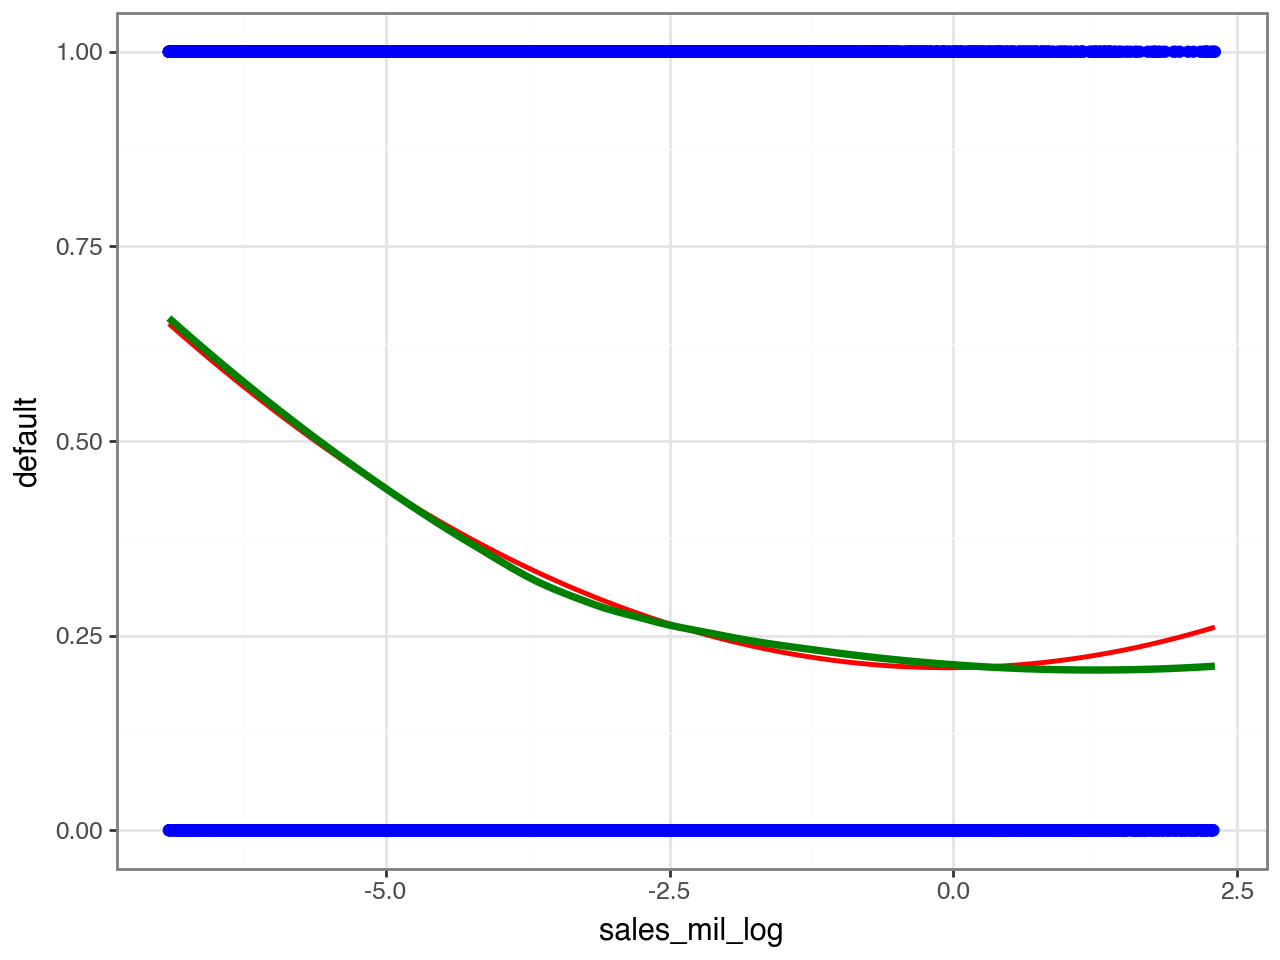

In [38]:
color = ['blue', 'red', 'green']

(
    ggplot(data, aes(x="sales_mil_log", y="fast_growth"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)


In [51]:
# Linear regressions
ols_s = smf.ols("fast_growth ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())


                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     410.9
Date:                Tue, 04 Mar 2025   Prob (F-statistic):          2.03e-175
Time:                        13:55:37   Log-Likelihood:                -12030.
No. Observations:               19036   AIC:                         2.407e+04
Df Residuals:                   19033   BIC:                         2.409e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2031      0.008  

In [40]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])


In [41]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    19036.000000
mean         8.701828
std          6.924531
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

In [42]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()


In [ ]:
data["profit_margin"] = data["profit_loss_year"] / data["sales"]

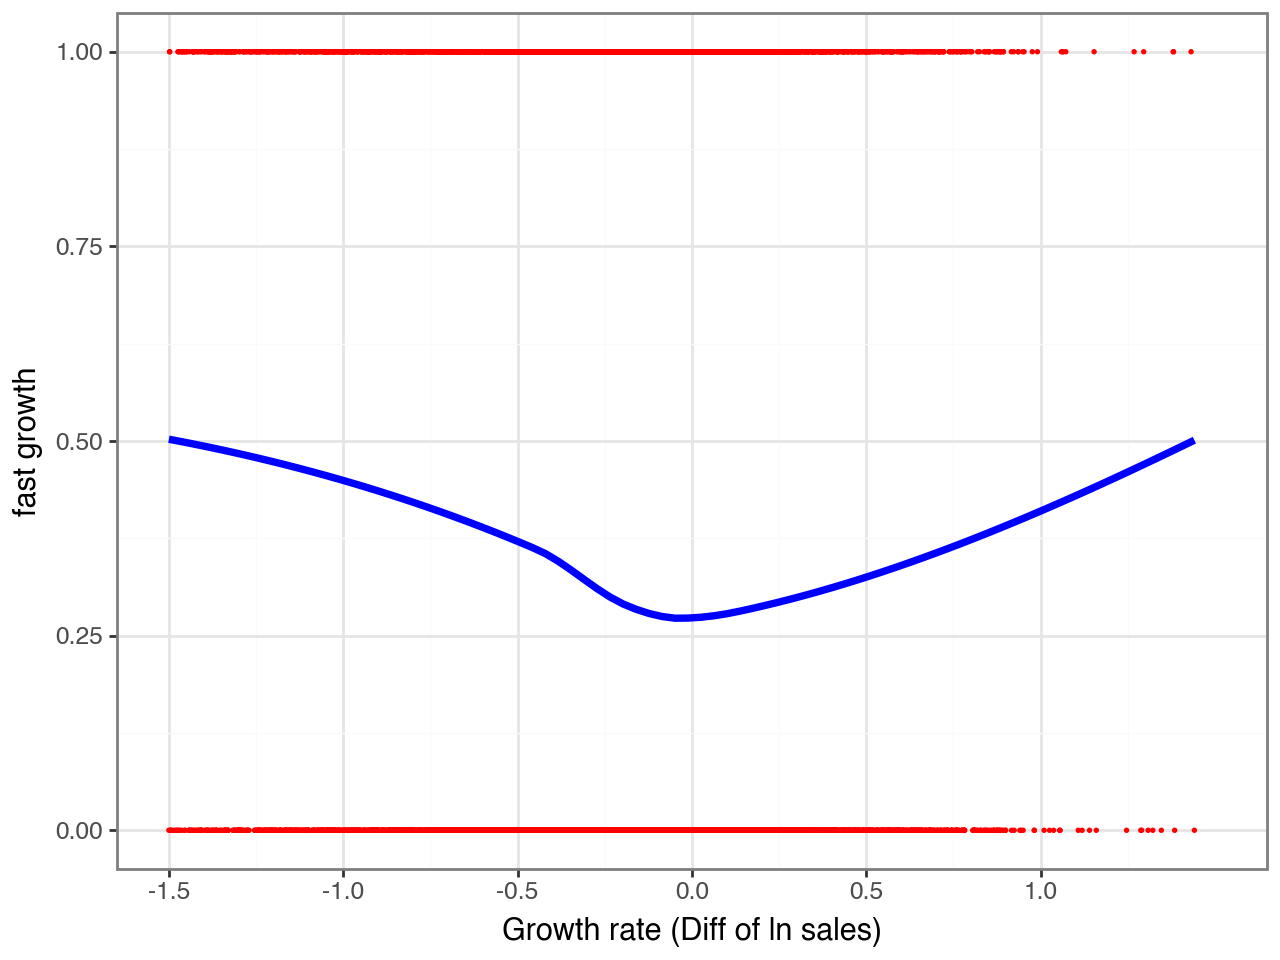

In [49]:
(
    ggplot(data, aes(x="profit_margin", y="fast_growth"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="fast growth")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=np.arange(-1.5, 1.5, 0.5))
    + theme_bw()
)


In [52]:
data.to_csv(path + "/firms_clean.csv", index=False)


In [44]:
data.columns.to_list()

['year',
 'comp_id',
 'begin',
 'end',
 'amort',
 'curr_assets',
 'curr_liab',
 'extra_exp',
 'extra_inc',
 'extra_profit_loss',
 'fixed_assets',
 'inc_bef_tax',
 'intang_assets',
 'inventories',
 'liq_assets',
 'material_exp',
 'personnel_exp',
 'profit_loss_year',
 'sales',
 'share_eq',
 'subscribed_cap',
 'tang_assets',
 'D',
 'balsheet_flag',
 'balsheet_length',
 'balsheet_notfullyear',
 'founded_year',
 'exit_year',
 'ceo_count',
 'foreign',
 'female',
 'birth_year',
 'inoffice_days',
 'gender',
 'origin',
 'nace_main',
 'ind2',
 'ind',
 'urban_m',
 'region_m',
 'founded_date',
 'exit_date',
 'ln_sales',
 'sales_mil',
 'sales_mil_log',
 'fast_growth',
 'ind2_cat',
 'age',
 'new',
 'age2',
 'foreign_management',
 'gender_m',
 'm_region_loc',
 'flag_asset_problem',
 'total_assets_bs',
 'extra_exp_pl',
 'extra_inc_pl',
 'extra_profit_loss_pl',
 'inc_bef_tax_pl',
 'inventories_pl',
 'material_exp_pl',
 'profit_loss_year_pl',
 'personnel_exp_pl',
 'intang_assets_bs',
 'curr_liab_bs',
 